## Google-Symptoms DAP Appendix II: Coefficients and Intercepts

Analyst: Jingjing

Advisors: Jacob and Nat

Stackholder: Ryan and Nigam

As memtioned in the report, the method used to fill missing dates does not matter much. Here in this appendix, we only condier datasets where the values for missing dates are filled with 0s.

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import re
from itertools import product
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import spearmanr, rankdata
import seaborn as sns

import pandas as pd
import numpy as np

import covidcast
from delphi_utils import GeoMapper


gmpr = GeoMapper()

In [3]:
symptom_sets = {
    "Respiratory": ["symptom:Cough", "symptom:Phlegm", "symptom:Shortness of breath", "symptom:Wheeze",
                        "symptom:Asthma", "symptom:Pneumonia", "symptom:Sore throat"],
    "Sensory": ["symptom:Anosmia", "symptom:Dysgeusia", "symptom:Ageusia"],
    "Fever": ["symptom:Fever", "symptom:Hyperthermia", "symptom:Chills", "symptom:Shivering"],
    "Fatigue": ["symptom:Fatigue", "symptom:Weakness"],
    "GI": ["symptom:Nausea", "symptom:Vomiting", "symptom:Diarrhea", "symptom:Indigestion",
          "symptom:Abdominal pain"],
    "Pain": ["symptom:Pain", "symptom:Sharp pain", "symptom:Chest pain", "symptom:Myalgia",
             "symptom:Arthralgia", "symptom:Eye pain", "symptom:Headache", "symptom:Migraine",
             "symptom:Cramp"]
}
gs_df = pd.read_csv("./raw/county_fillminratio_smoothed_google_symptoms_12_14.csv", parse_dates=["date"])
set_names = sorted(list(symptom_sets.keys()))
for set_name in set_names:
    
    # Get raw sum for symptoms in the same symptom sets
    gs_df[set_name] = gs_df[symptom_sets[set_name]].sum(axis=1) 

### Introduction

In the main DAP, for indicators generated using rawsum method, we show the visualization of coefficients and intercepts by the linear regression model. The number of counties considered for each symptom set is different. Though this is the nature of this dataset, the comparison is not strictly fair. Here we provide the visualization again for different symptom sets but consider only the counties that are available for symptoms in all of the 6 symptom sets. 

As for indicators generated with the regression method, we will show the median of coefficients and intercepts over the counties available for each symptom set respectively to help explain why we don't show it in the main DAP. 

### For rawsum

Before using the blend of static sensorization, we combine the values for symptoms within a specific symptom sets by taking the rawsum. As introduced in the report, for each date t and each location c, we train the linear regression model based on data from the first date (2020-02-20) to 7 days ago (date t-7). And the coefficients and intercepts returned by the linear regression model are labeled as parameters for date t and location c. 


When we use rawsum to combine multiple symptoms, we simply assign 0s to counties that are not available for a specific symptom but are included in the considered county list for the corresponding symptom sets. This means the rawsum will be dominated by a limited number of symptoms if only they have non-zero values for counties that are only available for them. For example, the value of fever will dominate the rawsum value of set Fever for most of the counties. 

In [8]:
# Filter out counties with more than 50% days unavailable
SYMPTOM_COUNTY_SET = {}
gs_df = pd.read_csv("./raw/county_google_symptoms_allcovid_12_14.csv", parse_dates=["date"])
n_days = (gs_df["date"].max() - gs_df["date"].min()).days + 1

gs_df = gs_df[~gs_df["geo_id"].isnull()]
gs_df["geo_id"] = [str(int(x)).zfill(5) for x in gs_df["geo_id"]]

for idx in range(2, gs_df.columns.shape[0]):
    symptom = gs_df.columns[idx].split(":")[1]
    subdf = gs_df[[gs_df.columns[idx], "geo_id", "date"]].dropna()
    subdf.loc[subdf[gs_df.columns[idx]] == 0, gs_df.columns[idx]] = np.nan
    mask_df = subdf.groupby("geo_id").count()

    geo_list = set(mask_df[mask_df[gs_df.columns[idx]] >= n_days*0.5].index.values)

    SYMPTOM_COUNTY_SET[gs_df.columns[idx]] = geo_list

# Get the list of counties shared by all the related symptoms
shared_locs = SYMPTOM_COUNTY_SET["symptom:Pain"]
for signal in signal_list:
    for sym in symptom_sets[signal]:
        shared_locs = shared_locs.intersection(SYMPTOM_COUNTY_SET[sym])

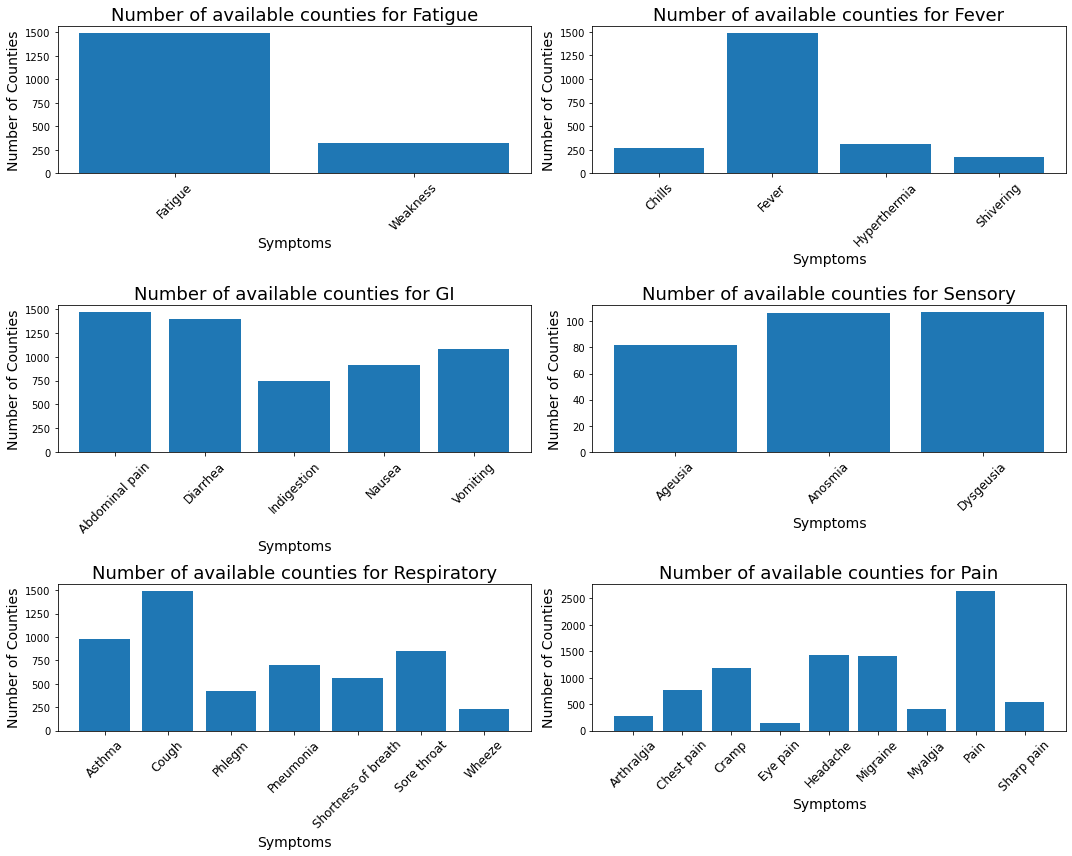

In [23]:
plt.figure(figsize = (15, 12))
i=1
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    sym_list = []
    geo_num = []
    for sym in sorted(symptom_sets[signal]):
        sym_list.append(sym.split(":")[1])
        geo_num.append(len(SYMPTOM_COUNTY_SET[sym]))
    plt.bar(sym_list, geo_num)
    plt.title("Number of available counties for %s"%signal, fontsize=18)
    plt.xlabel("Symptoms", fontsize=14)
    plt.ylabel("Number of Counties", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
    

Though taking the raw sums to combine multiple symptoms within symptom sets is simple and is computationally efficient compared to regression, the results values are not able to well summarize the popularity of symptoms considered due to the difference in overall popularity and spatial distribution. Fever, Respiratory, and Pain are the top 3 symptom sets affected by this because all of them have a special symptom. The number of available counties of them is much larger than that of other symptoms in the same symptom sets. 

In the plot shown below, we show the median of coefficients and intercepts returned by linear regression for all the symptom sets. All the available counties are considered for the black lines while only 82 counties, which are shared by all the symptoms included in symptom sets, are taken into account for the red lines. 

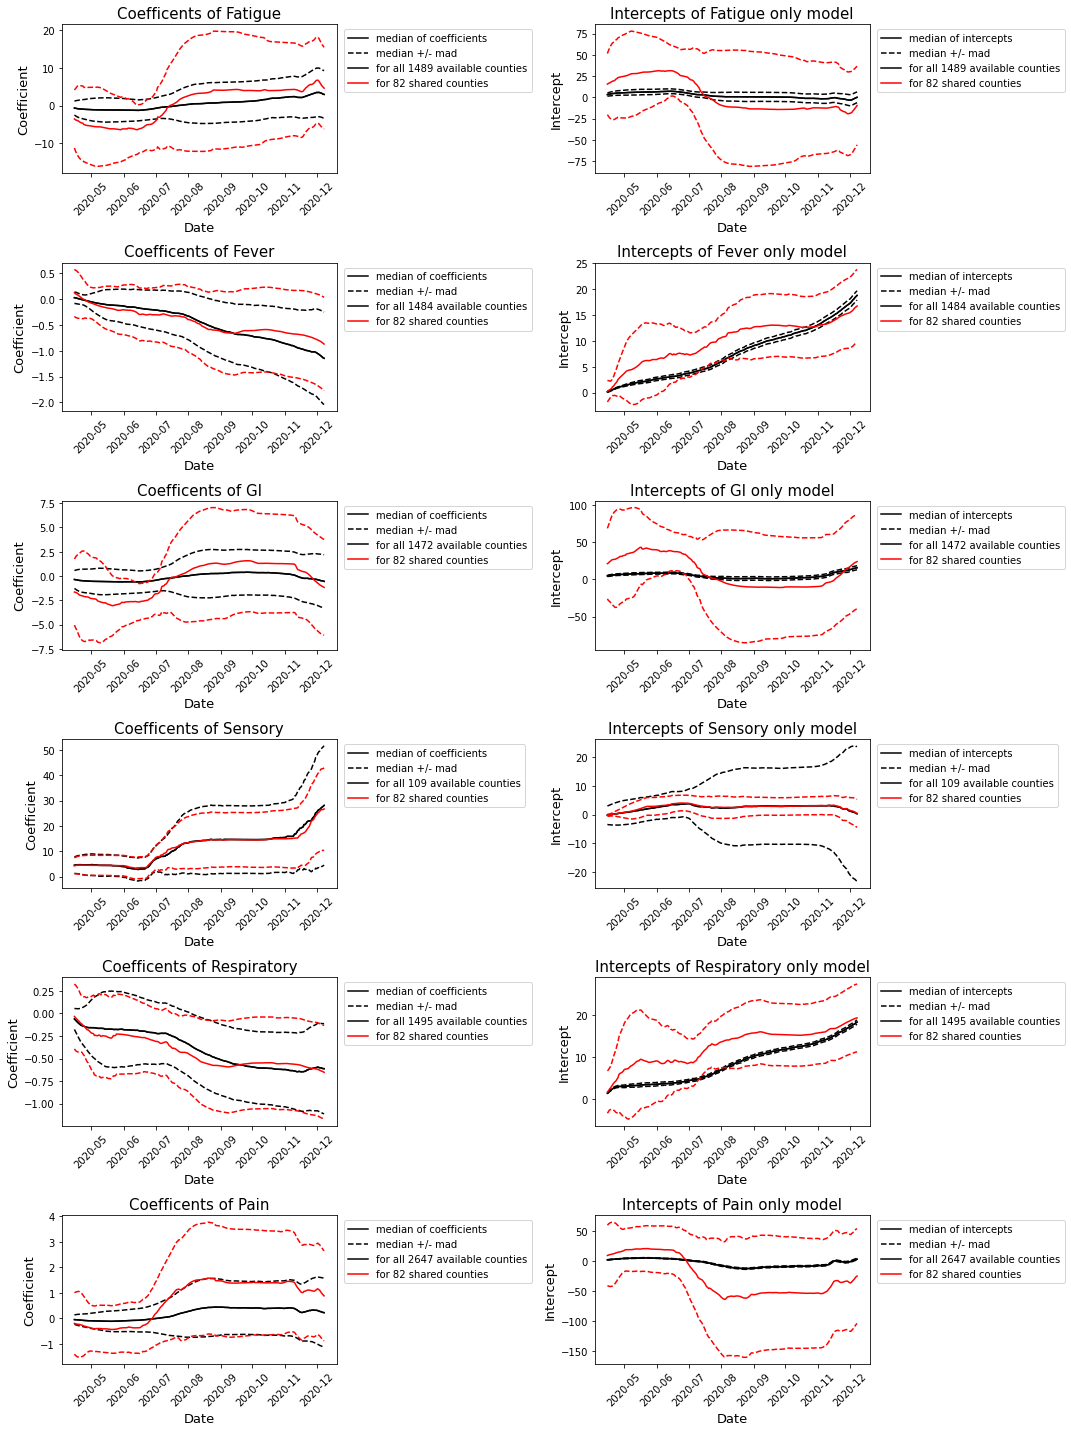

In [24]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (15, 20))
i=1
for signal in signal_list:
    # Read sensorization result
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_rawsum_fill0_sensorization_12_14.csv"%signal,
                    parse_dates=["date"])
    df = df.loc[df["date"] >= datetime(2020, 4, 15)]
    median_df = df.groupby("date").median().reset_index().drop(["geo_id"], axis=1)
    mad_df = df.groupby("date").mad().reset_index().drop(["geo_id"], axis=1)
    summary_df = median_df.merge(mad_df, on="date", suffixes=["_median", "_mad"])
    
    subdf = df[df["geo_id"].isin(shared_locs)] # consider counties shared by all the related symptoms only
    sub_median_df = subdf.groupby("date").median().reset_index().drop(["geo_id"], axis=1)
    sub_mad_df = subdf.groupby("date").mad().reset_index().drop(["geo_id"], axis=1)
    sub_summary_df = sub_median_df.merge(sub_mad_df, on="date", suffixes=["_median", "_mad"])
    
    plt.subplot(6, 2, i)
    plt.plot(summary_df["date"], summary_df["coef_median"], color = "black", label="median of coefficients")
    plt.plot(summary_df["date"], summary_df["coef_median"] + summary_df["coef_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["coef_median"] - summary_df["coef_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["coef_median"], color = "black", label="for all %d available counties"%df["geo_id"].unique().shape[0])

    plt.plot(sub_summary_df["date"], sub_summary_df["coef_median"], color = "red", label="for %d shared counties"%len(shared_locs))
    plt.plot(sub_summary_df["date"], sub_summary_df["coef_median"] + sub_summary_df["coef_mad"], 
             color = "red", linestyle = "--")
    plt.plot(sub_summary_df["date"], sub_summary_df["coef_median"] - sub_summary_df["coef_mad"], 
             color = "red", linestyle = "--")
    plt.title("Coefficents of %s"%(signal), fontsize=15)
    plt.legend(bbox_to_anchor=(1.01, 1))
    plt.xticks(rotation=45)
    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Coefficient", fontsize=13)
    
    
    plt.subplot(6, 2, i+1)
    plt.plot(summary_df["date"], summary_df["intercept_median"], color = "black", label="median of intercepts")
    plt.plot(summary_df["date"], summary_df["intercept_median"] + summary_df["coef_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["intercept_median"] - summary_df["coef_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["intercept_median"], color = "black", label="for all %d available counties"%df["geo_id"].unique().shape[0])

    plt.plot(sub_summary_df["date"], sub_summary_df["intercept_median"], color = "red", label="for %d shared counties"%len(shared_locs))
    plt.plot(sub_summary_df["date"], sub_summary_df["intercept_median"] + sub_summary_df["intercept_mad"], 
             color = "red", linestyle = "--")
    plt.plot(sub_summary_df["date"], sub_summary_df["intercept_median"] - sub_summary_df["intercept_mad"], 
             color = "red", linestyle = "--")        
    plt.title("Intercepts of %s only model"%signal, fontsize=15)
    plt.legend(bbox_to_anchor=(1.01, 1))
    plt.xticks(rotation=45)
    plt.xlabel("Date", fontsize=13)
    plt.ylabel("Intercept", fontsize=13)            
    i+=2
plt.tight_layout()    

### For regression

Different from rawsum, here we combine the values for symptoms within a specific symptom sets by considering them as different features when training linear regression model. The coefficients and intercepts returned by the linear regression model that is trained based on data in location c from the first date (2020-02-20) to 7 days ago (date t-7) are labeled as parameters for date t and location c. The same, the list of available counties are different for different symptom sets. 

Here we show the median of coefficients and intercepts returned by linear regression models across all the counties available for each symptom set. As mentioned in the report, it's reasonable to have 0 coefficients for most of the symptoms since their geographical coverage is significantly low compared with the "dominant" symptom in the same symptom set. 

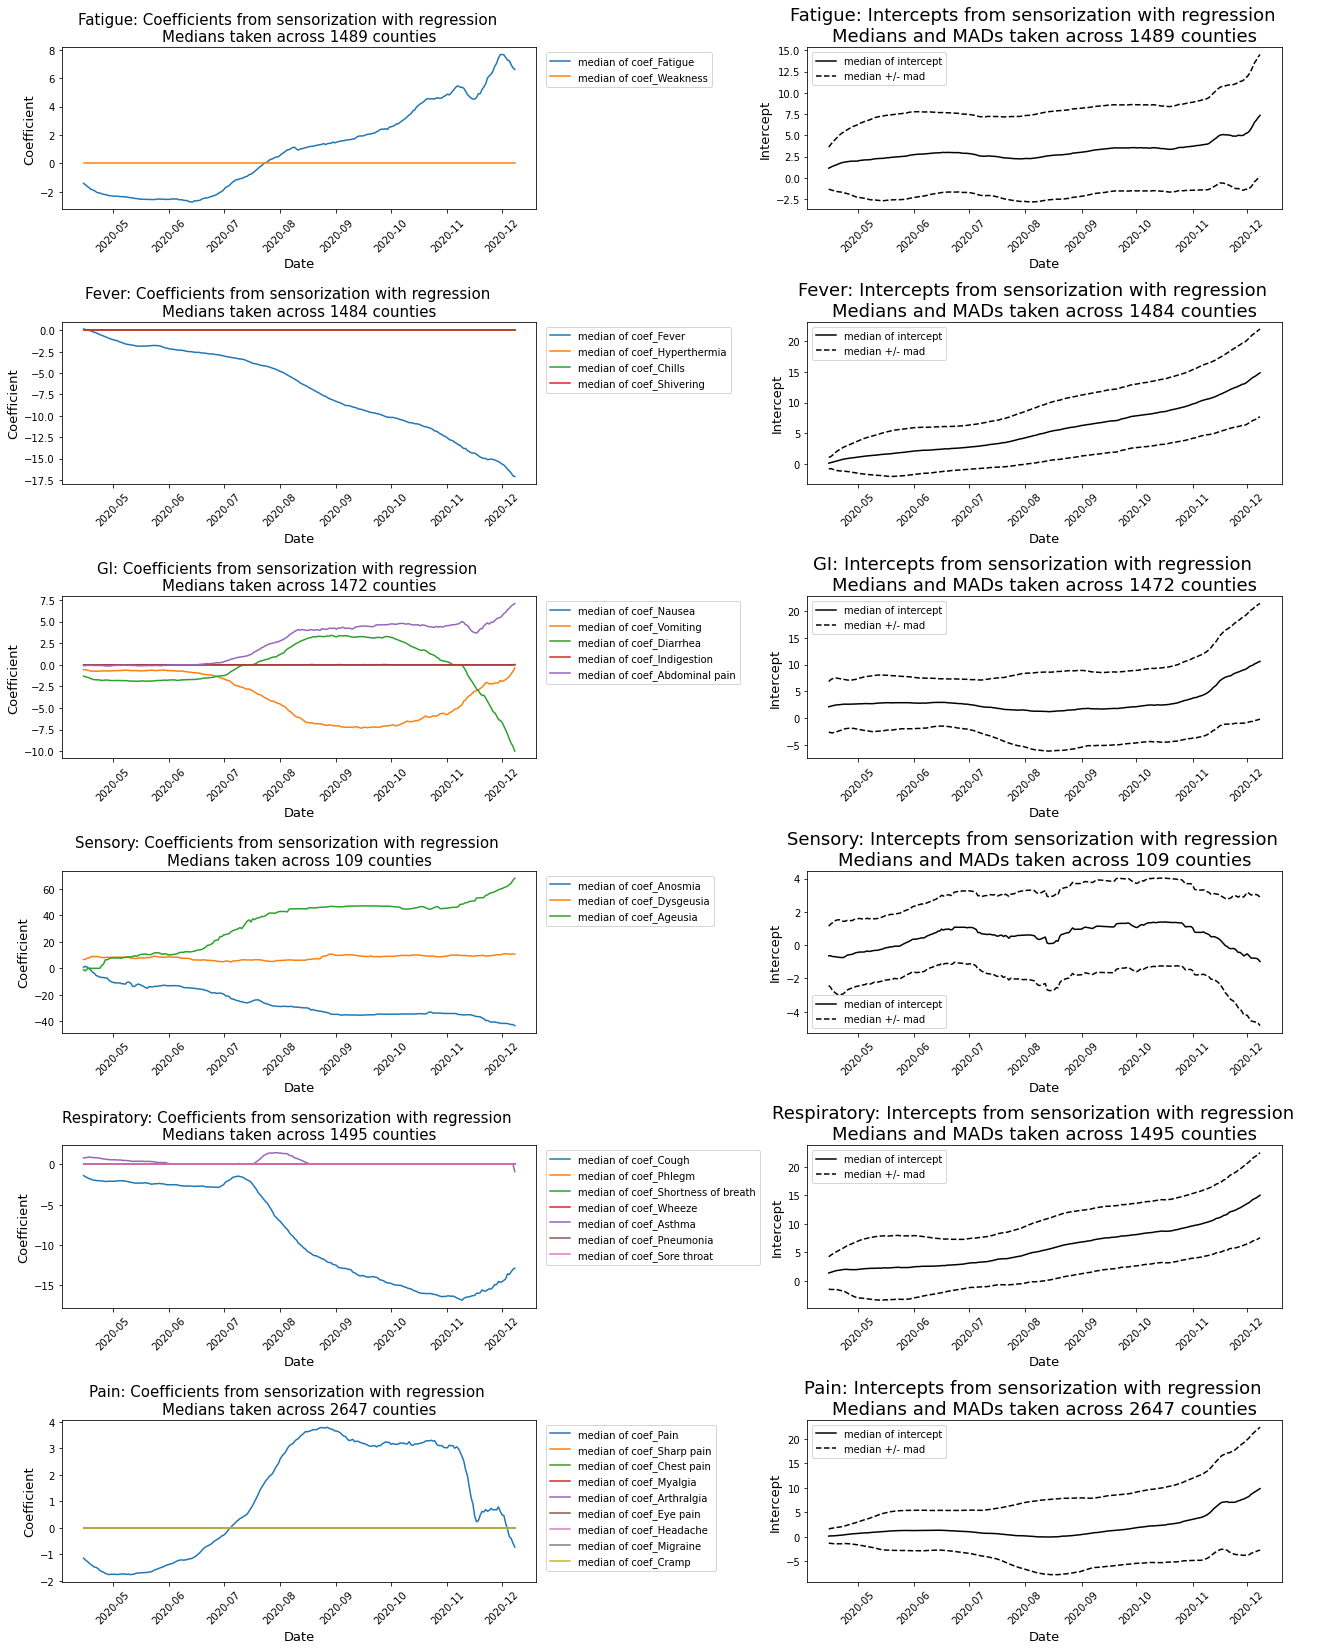

In [25]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (18, 26))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    # Read sensorization result
    df = pd.read_csv("./sensorization_with_as_of_02/sensored/%s_regression_fill0_sensorization_12_14.csv"%signal,
                    parse_dates=["date"])
    df = df.loc[df["date"] >= datetime(2020, 4, 15)]
    
    median_df = df.groupby("date").median().reset_index().drop(["geo_id"], axis=1)
    mad_df = df.groupby("date").mad().reset_index().drop(["geo_id"], axis=1)
    summary_df = median_df.merge(mad_df, on="date", suffixes=["_median", "_mad"])
    geo_list = df["geo_id"].unique()
    
    plt.subplot(7, 2, i)
    selected_idx = [j for j in range(df.shape[1]) if "coef" in df.columns[j]]
    for idx in selected_idx:
        col = df.columns[idx]
        plt.plot(median_df["date"], median_df[col], label="median of " + col)
    plt.legend(bbox_to_anchor=(1.01, 1))
    plt.title("%s: Coefficients from sensorization with regression\
     \nMedians taken across %d counties"%(signal, len(geo_list)), fontsize=15)
    plt.xticks(rotation=45)
    plt.xlabel("Date", fontsize = 13)
    plt.ylabel("Coefficient", fontsize = 13)
    
    plt.subplot(7, 2, i+1)
    plt.plot(summary_df["date"], summary_df["intercept_median"], color = "black", label="median of intercept")
    plt.plot(summary_df["date"], summary_df["intercept_median"] + summary_df["intercept_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["intercept_median"] - summary_df["intercept_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.title("%s: Intercepts from sensorization with regression\
    \nMedians and MADs taken across %d counties"%(signal, len(geo_list)), fontsize=18)
    plt.legend()
    plt.xlabel("Date", fontsize = 13)
    plt.ylabel("Intercept", fontsize = 13)
    plt.xticks(rotation=45)
    i+=2
plt.tight_layout()  